# Extracting and preparing the data

In [1]:
import cv2
import numpy as np
import random
import os

## Gamma Function

Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems.

In [2]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [3]:
data = []
gamma = 2.5
normal_count = 0
pneumonia_count = 0
img_size = 150
assign_dict = {"NORMAL":0, "PNEUMONIA":1}

def get_data(directory):
    for sub_directory in os.listdir(directory):
        if sub_directory == "NORMAL":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
                
        if sub_directory == "PNEUMONIA":
            inner_directory = os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img = cv2.imread(os.path.join(inner_directory,i),0)
                img =  adjust_gamma(img, gamma=gamma)
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,assign_dict[sub_directory]])
    random.shuffle(data)  
    return np.array(data)

## Loading the dataset

In [4]:
train = get_data('../chest_xray/train')
val = get_data('../chest_xray/val')
test = get_data('../chest_xray/test')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
import os
image_count = []

directory = '../chest_xray/train'
total_image = 0
'''
  Display  amount of data normal and pneumonia
'''

def data_image(directory, total_image):
    for category in os.listdir(directory):
        img_dir = os.path.join(directory, category)
        img = len(os.listdir(img_dir))
        # Tampung gambar
        image_count.append(img)
        total_image += img
        print(f"{category} : {img}")
    print("Total Image : ", total_image)

data_image(directory,total_image)

PNEUMONIA : 3875
NORMAL : 1341
Total Image :  5216


Let's see a random pair of `NORMAL` versus `PNEUMONIA`

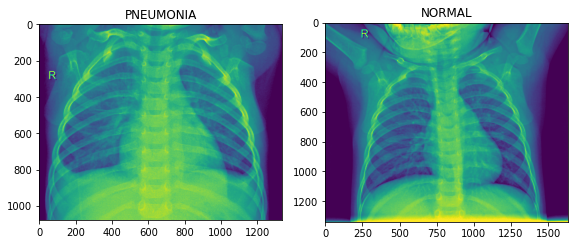

In [6]:
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

fig = plt.figure(figsize = (20,15))
ax = []
i = 1

new_dir = '../chest_xray/train'

for image in os.listdir(new_dir):
    ax.append(fig.add_subplot(1,5,i))
    i += 1
    ax[-1].set_title(str(image))
    image_folder = os.path.join(new_dir, image)
    rnd_number = randint(0, len(os.listdir(image_folder)))
    image_file = os.listdir(image_folder)[rnd_number]
    image_file = os.path.join(image_folder, image_file)
    image_show = mpimg.imread(image_file)
    plt.imshow(image_show)

fig.tight_layout()
plt.show()

In [7]:
x_train = []
y_train = []
for features,label in train:
    x_train.append(features)
    y_train.append(label)

In [8]:
x_value = []
y_value = []
for features, label in val:
    x_value.append(features)
    y_value.append(label)

In [9]:
x_test = []
y_test = []
for features, label in test:
    x_test.append(features)
    y_test.append(label)

We try to normalize the data (range of pixel value)

In [10]:
x_train = np.array(x_train) / 255
x_val = np.array(x_value) / 255
x_test = np.array(x_test) / 255

We resize the data for deep learning

In [11]:
img_size = 150


x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_value)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data augmentation

- We use `Data Augmentation` to increase the number of Data Points in our dataset.
- This procedure has the purpose of avoiding the oferfitting problems by expanding the dataset.
- The solutions in our case are: fillping the image, zooming the image, cropping etc.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.3, 
                              min_lr=0.000001)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32),
                                 epochs = 10 ,
                                 validation_data = datagen.flow(x_val, y_val),
                                 callbacks = [reduce_lr])

Epoch 1/10
163/163 [==============================] - 142s 871ms/step - loss: 0.0969 - accuracy: 0.9678 - val_loss: 0.0990 - val_accuracy: 0.9669
Epoch 2/10
163/163 [==============================] - 150s 920ms/step - loss: 0.1037 - accuracy: 0.9640 - val_loss: 0.3142 - val_accuracy: 0.8498
Epoch 3/10
163/163 [==============================] - 150s 921ms/step - loss: 0.0916 - accuracy: 0.9666 - val_loss: 0.4110 - val_accuracy: 0.8945

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 4/10
163/163 [==============================] - 152s 932ms/step - loss: 0.0947 - accuracy: 0.9682 - val_loss: 0.0919 - val_accuracy: 0.9713
Epoch 5/10
163/163 [==============================] - 152s 932ms/step - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.6337 - val_accuracy: 0.8549
Epoch 6/10
163/163 [==============================] - 150s 919ms/step - loss: 0.0874 - accuracy: 0.9703 - val_loss: 0.1030 - val_accuracy: 0.9595

Epoch 00006: ReduceLROnPlateau reducing le

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1])

183/183 [==============================] - 34s 187ms/step - loss: 0.1231 - accuracy: 0.9542
Loss of the model is -  0.12307064980268478
183/183 [==============================] - 35s 190ms/step - loss: 0.1231 - accuracy: 0.9542
Accuracy of the model is -  0.9542349576950073


In [34]:
from sklearn.metrics import classification_report

predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.93      0.92      1583
   Normal (Class 1)       0.97      0.96      0.97      4273

           accuracy                           0.95      5856
          macro avg       0.94      0.95      0.94      5856
       weighted avg       0.95      0.95      0.95      5856



In [27]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [28]:
correct, incorrect

(array([   0,    1,    2, ..., 5853, 5854, 5855]),
 array([  24,   32,   61,   77,  109,  123,  127,  155,  198,  212,  217,
         223,  249,  253,  256,  274,  275,  282,  305,  310,  311,  318,
         407,  409,  410,  440,  456,  458,  479,  487,  500,  535,  577,
         608,  632,  645,  652,  659,  665,  676,  699,  707,  722,  770,
         783,  820,  826,  828,  874,  876,  912,  933,  975, 1017, 1041,
        1078, 1108, 1135, 1151, 1167, 1237, 1307, 1315, 1337, 1345, 1351,
        1356, 1362, 1377, 1384, 1392, 1440, 1464, 1485, 1520, 1539, 1556,
        1564, 1566, 1570, 1582, 1588, 1605, 1619, 1638, 1685, 1691, 1704,
        1711, 1767, 1802, 1817, 1824, 1870, 1894, 1896, 1947, 1953, 1967,
        1983, 2018, 2032, 2051, 2102, 2109, 2113, 2170, 2214, 2229, 2236,
        2242, 2252, 2291, 2312, 2358, 2362, 2370, 2401, 2408, 2468, 2483,
        2498, 2499, 2516, 2529, 2552, 2556, 2567, 2598, 2600, 2606, 2647,
        2650, 2663, 2705, 2734, 2756, 2758, 2764, 2799, 2814,

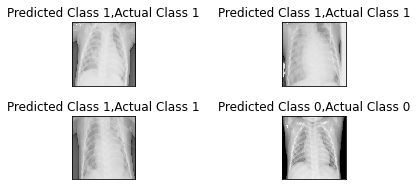

In [32]:
i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [47]:
model.save('../chest_xray/')

INFO:tensorflow:Assets written to: ../chest_xray/assets


In [3]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

NameError: name 'model' is not defined